# Dataset generation

In [ ]:
import os
import config_gen
import numpy as np
from functions import (
    generate_random_line,
    get_points,
    spatial_limits,
    missed_stave,
    Probmiss,
    ProbNoise,
    dist_z,
    stavew,
    Lgap,
    noise_gen,
    save_csv_py,
    data,
)
from pathlib import Path
dir = Path(os.path.abspath(""))

In [ ]:
num_samples = 100#config_gen.N_EVGEN # Change the number of generated event here or in the config file
os.makedirs(dir / "data", exist_ok=True) # A folder named data is created in the same dir of this file
outfile =[dir / "data" / f"sim_{i}.csv" for i in range(1,11)]    # data saved in sim_{i}.csv
count = 0

for idx, file_path in enumerate(outfile):
    print(f"Processing file: {file_path}")
    num_plots, num_gen_events = 0, 0
    cont = []
    while num_gen_events <= num_samples:
        point, direction = generate_random_line()  # Inputs can be adjusted in the function
        points_on_line = get_points(direction, point, [0., -dist_z, -2*dist_z])

        if spatial_limits(points_on_line):
            
            points = points_on_line.reshape(-1, 3)
            #print(points.shape)

            mask_missed = np.array([missed_stave(y, stavew, Lgap) for y in points[:,1]])

            points = points[~mask_missed]

            # Introducing noise
            if len(points) > 0:

                rand_vals = np.random.uniform(0, 1, size=len(points))
                points = points[rand_vals >= Probmiss]

            if points.shape[0] >=3:

                points_on_line = points.reshape(-1, 3)
                cont.append(data(num_gen_events, points_on_line, direction, point, num_plots+1))
                num_plots += 1
            
            noise = noise_gen(ProbNoise, dist_z)
            cont.append(data(num_gen_events, noise, np.zeros_like(direction), np.zeros_like(point), -1))
        if num_plots == (idx+1):
            num_plots = 0
            num_gen_events += 1
        if num_gen_events%500 == 0:
            print(num_gen_events)

        count += 1

    save_csv_py(cont, file_path)

## Direction of the generated particles

Dataset generation

In [ ]:
import os
import numpy as np
import csv
from functions import (
    spatial_limits,
    get_points,
    missed_stave,
    generate_random_line,
    Probmiss,
    dist_z,
    stavew,
    Lgap,
)
from pathlib import Path
dir = Path(os.path.abspath(""))

In [ ]:
os.makedirs(dir / "dirs", exist_ok=True) # A folder named dirs is created in the same dir of this file
paths = [os.path.join(dir, "dirs", f"{name}.csv") for name in ["dir_iso", "dir_inc"]]
flag = True

num_samples = 100000
for outfile in paths:
    directions_list = np.empty((num_samples, 3), dtype=float)
    num_gen_events = 0

    while num_gen_events < num_samples:
        point, direction = generate_random_line(uniform_theta=flag)
        points_on_line = get_points(direction, point, [0., -dist_z, -2 * dist_z])

        if not spatial_limits(points_on_line):
            continue

        points = points_on_line.reshape(-1, 3)
        mask_missed = np.fromiter((missed_stave(y, stavew, Lgap) for y in points[:, 1]), dtype=bool, count=len(points))
        points = points[~mask_missed]

        if points.size == 0:
            continue

        rand_vals = np.random.rand(len(points))
        points = points[rand_vals >= Probmiss]

        if points.shape[0] > 0:
            directions_list[num_gen_events] = direction
            num_gen_events += 1

    header = ['dx', 'dy', 'dz']
    np.savetxt(outfile, directions_list, delimiter=",", header=",".join(header), comments='', fmt="%.6f")
    flag = not flag
    

Angular distribution visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
plt.rcParams.update({'font.size': 14})
from pathlib import Path
from functions import (
    asSpherical
)
dir = Path(os.path.abspath(""))

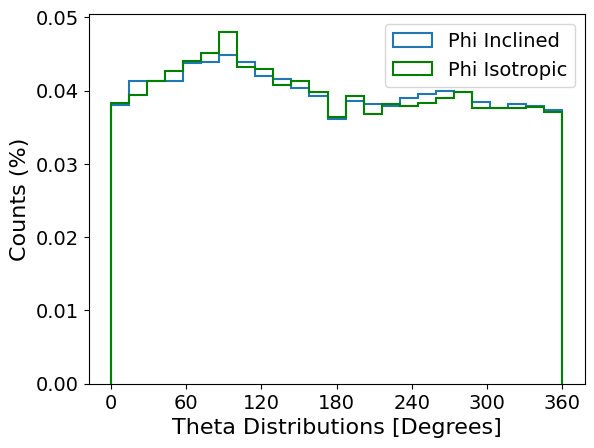

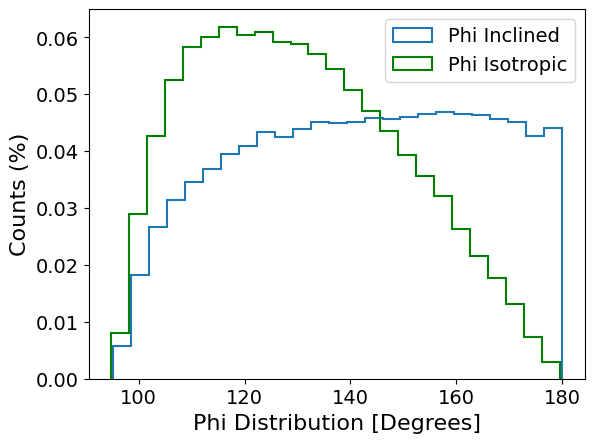

In [3]:
paths = [os.path.join(dir, "dirs", f"{name}.csv") for name in ["dir_iso", "dir_inc"]]

direction = pd.read_csv(paths[0]).values
sph = np.vstack(asSpherical(direction))
a = np.sort(sph[:,1])
phi = []
for i in a:
    if i>0:
        phi.append(i)
    else:
        phi.append(360+i)
phi1 = np.sort(phi)
theta1 = np.sort(sph[:,0])

direction = pd.read_csv(paths[1]).values
sph = np.vstack(asSpherical(direction))
a = np.sort(sph[:,1])
phi = []
for i in a:
    if i>0:
        phi.append(i)
    else:
        phi.append(360+i)
phi2 = np.sort(phi)
theta2 = np.sort(sph[:,0])


# Histogram generation

counts, bins = np.histogram(phi1,25)

plt.hist(bins[:-1], bins, weights=counts/np.sum(counts), histtype="step",lw=1.5,label="Phi Inclined")

counts, bins = np.histogram(phi2,25)

plt.hist(bins[:-1], bins, weights=counts/np.sum(counts), histtype="step",lw=1.5,label="Phi Isotropic",color="green")

plt.ylabel("Counts (%)", fontsize=16)
plt.xlabel("Theta Distributions [Degrees]", fontsize=16)
plt.xticks(np.arange(0, 420, 60), fontsize=14)
plt.yticks(fontsize=14)

plt.legend()

plt.show()


counts, bins = np.histogram(theta1,25)

plt.hist(bins[:-1], bins, weights=counts/np.sum(counts), histtype="step",lw=1.5,label="Phi Inclined")

counts, bins = np.histogram(theta2,25)

plt.hist(bins[:-1], bins, weights=counts/np.sum(counts), histtype="step",lw=1.5,label="Phi Isotropic",color="green")

plt.ylabel("Counts (%)", fontsize=16)
plt.xlabel("Phi Distribution [Degrees]", fontsize=16)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 

plt.legend()

plt.show()


# Reconstructions algorithms:

## Combinatorial Method

In [5]:
import csv
from tqdm import tqdm
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from functions import (
    data_t_gen,
    get_combinations,
    read_csv_py,
    chi2_line,
    dist_z,
    
)
path = Path(os.path.abspath(""))

Saving the reconstructed data

In [ ]:
file_list = [path / "data" / f"sim_{i}.csv" for i in range(1, 11)]
reconstructed = []
not_reconstructed = []
from_start = []
single_points = []

os.makedirs(path / "reconstructed", exist_ok=True)
reconstructed_names = [path / "reconstructed" / "reco_C_{i}.csv" for i in range(1, 11)]


def write_to_csv(file_name, data):
    with open(file_name, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)


start = datetime.now()

for l, file_name in enumerate(file_list):
    output_name = reconstructed_names[l]
    x, y, z, ev, trk = read_csv_py(file_name)
    content = data_t_gen(x, y, z, ev, trk)

    correctly_reconstructed_tracks = 0
    not_reconstructed_tracks = 0
    single_point_tracks = 0
    missing_from_start = 0

    data_buffer = []
    num_events = content[-1].indexev

    for idx__, i in tqdm(enumerate(range(num_events)), total=num_events, desc=f"Processing {file_name}"):
        points = []
        points_on_line = []
        points_reco = []
        direction = []
        chi2min = 10000
        index = -1

        mask_points = np.array([int(c.indexev) == i for c in content])
        points_list = [c.points for c, mask in zip(content, mask_points) if mask]
        points = np.vstack(points_list) if points_list else np.empty((0, 3))

        track_index_list = [int(c.id) * np.ones(len(c.points)) for c, mask in zip(content, mask_points) if mask]
        track_index = np.concatenate(track_index_list) if track_index_list else np.empty((0,))

        if len(points) == 0:
            missing_from_start += 1
            continue

        prev_len = -1

        while len(points) > 1 and len(points) != prev_len:
            prev_len = len(points)
            combinations = get_combinations(points, dist_z)
            num_combinations = len(combinations)
            index = -1
            chi2min = 10000

            if num_combinations > 0:
                for k in range(num_combinations):
                    p = np.array(combinations[k])
                    line, chi2 = chi2_line(p)

                    if chi2 < chi2min:
                        chi2min = chi2
                        index = k
                        direction = line.direction / np.linalg.norm(line.direction)
                        points_on_line = combinations[index][0]

                if index == -1:
                    not_reconstructed_tracks += 1
                    for k in range(num_combinations):
                        mask = np.ones(len(points), dtype=bool)
                        for pt in combinations[k]:
                            idx = np.where(np.all(np.isclose(points, pt), axis=1))[0]
                            if idx.size > 0:
                                mask[idx[0]] = False
                        points_reco = points[~mask]
                        points = points[mask]
                        track_index = track_index[mask]
                        data_buffer.extend([[i, 0, 0, 0, 0] + list(pt) for pt in points_reco])
                else:
                    mask = np.ones(len(points), dtype=bool)
                    for pt in combinations[index]:
                        idx = np.where(np.all(np.isclose(points, pt), axis=1))[0]
                        if idx.size > 0:
                            mask[idx[0]] = False

                    id_rec = track_index[~mask]
                    y = 1 if np.all(id_rec == id_rec[0]) and chi2min < 3 else 0

                    if y == 1:
                        correctly_reconstructed_tracks += 1
                    else:
                        not_reconstructed_tracks += 1

                    points_reco = points[~mask]
                    data_buffer.extend([[i, y] + list(direction) + list(pt) for pt in points_reco])
                    points = points[mask]
                    track_index = track_index[mask]

            elif len(points) == 2:
                y = 1 if np.all(track_index[:2] == track_index[0]) else 0
                if y == 1:
                    correctly_reconstructed_tracks += 1
                else:
                    not_reconstructed_tracks += 1

                line = Line.best_fit(points)
                direction = line.direction / np.linalg.norm(line.direction)
                points_on_line = points[0]
                points_reco = points
                data_buffer.extend([[i, y] + list(direction) + list(points_on_line) + list(pt) for pt in points_reco])
                break

        if len(points) == 1:
            single_point_tracks += 1
            direction = np.zeros(3)
            points_on_line = points[0]
            data_buffer.extend([[i, 0] + list(direction) + list(points[0])])

        if len(data_buffer) >= 5000:
            write_to_csv(output_name, data_buffer)
            data_buffer = []

    if data_buffer:
        write_to_csv(output_name, data_buffer)

    reconstructed.append(correctly_reconstructed_tracks)
    not_reconstructed.append(not_reconstructed_tracks)
    single_points.append(single_point_tracks)
    from_start.append(missing_from_start)

    print(f"✔️ File {l+1} completed — Reconstructed: {correctly_reconstructed_tracks}, Not reconstructed: {not_reconstructed_tracks}, Singles: {single_point_tracks}, Missing: {missing_from_start}")
    now = datetime.now()
    elapsed = now - start
    timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] Iteration {l+1} ({elapsed}) - Processing {file_name}")


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_1.csv: 100%|██████████| 100/100 [00:00<00:00, 668.57it/s]


✔️ File 1 completed — Reconstructed: 88, Not reconstructed: 12, Singles: 0, Missing: 0
[2025-10-07 10:34:43] Iteration 1 (0:00:00.249930) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_1.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_2.csv: 100%|██████████| 100/100 [00:00<00:00, 200.19it/s]


✔️ File 2 completed — Reconstructed: 169, Not reconstructed: 31, Singles: 0, Missing: 0
[2025-10-07 10:34:44] Iteration 2 (0:00:00.869746) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_2.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_3.csv: 100%|██████████| 100/100 [00:01<00:00, 66.54it/s]


✔️ File 3 completed — Reconstructed: 242, Not reconstructed: 58, Singles: 0, Missing: 0
[2025-10-07 10:34:46] Iteration 3 (0:00:02.479768) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_3.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_4.csv: 100%|██████████| 100/100 [00:04<00:00, 23.51it/s]


✔️ File 4 completed — Reconstructed: 352, Not reconstructed: 48, Singles: 0, Missing: 0
[2025-10-07 10:34:50] Iteration 4 (0:00:06.934137) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_4.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_5.csv: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


✔️ File 5 completed — Reconstructed: 435, Not reconstructed: 65, Singles: 0, Missing: 0
[2025-10-07 10:34:59] Iteration 5 (0:00:15.394053) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_5.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_6.csv: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


✔️ File 6 completed — Reconstructed: 527, Not reconstructed: 73, Singles: 0, Missing: 0
[2025-10-07 10:35:17] Iteration 6 (0:00:34.025145) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_6.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_7.csv: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


✔️ File 7 completed — Reconstructed: 606, Not reconstructed: 94, Singles: 0, Missing: 0
[2025-10-07 10:35:51] Iteration 7 (0:01:07.358546) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_7.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_8.csv: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


✔️ File 8 completed — Reconstructed: 685, Not reconstructed: 115, Singles: 0, Missing: 0
[2025-10-07 10:36:35] Iteration 8 (0:01:52.235944) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_8.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_9.csv: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


✔️ File 9 completed — Reconstructed: 766, Not reconstructed: 134, Singles: 0, Missing: 0
[2025-10-07 10:37:59] Iteration 9 (0:03:15.857797) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_9.csv


Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_10.csv: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

✔️ File 10 completed — Reconstructed: 887, Not reconstructed: 113, Singles: 0, Missing: 0
[2025-10-07 10:39:36] Iteration 10 (0:04:52.417790) - Processing /home/luca/Uni/Triennale/VI/Tesi/prog_tesi/final/data/sim_10.csv


Creating the reconstruction plot

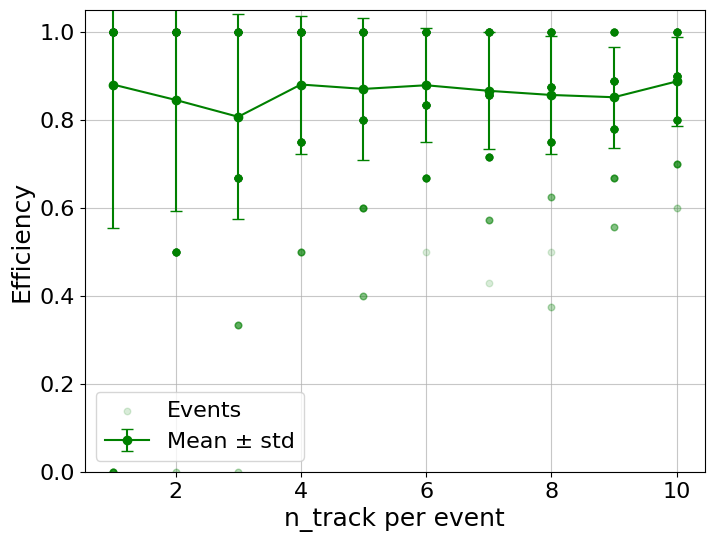

In [ ]:
DECIMALS = 6

file_list = [path / "reconstructed" / f"reco_{i}.csv" for i in range(1, 11)]
all_perf = []
os.makedirs(path / "res", exist_ok=True)


for n_track, name in enumerate(file_list, start=1):
    df = pd.read_csv(name, header=None, on_bad_lines='skip', names=['event', 'reco_id', 'vx', 'vy', 'vz', 'x', 'y', 'z'])

    df[['vx', 'vy', 'vz']] = df[['vx', 'vy', 'vz']].round(DECIMALS)

    grouped = (
        df.groupby(['event', 'vx', 'vy', 'vz'], as_index=False)
        .agg(correct_group=('reco_id', lambda s: (s == 1).all()))
    )

    summary = grouped.groupby('event', as_index=False)['correct_group'].agg(
        total='count', correct='sum'
    )

    summary['accuracy'] = (summary['correct'] / n_track).clip(upper=1)
    summary['n_track'] = n_track
    summary['file'] = name

    bad = summary[summary['correct'] > n_track]
    if not bad.empty:
        print(f"{name} events with correct > n_track:", bad['event'].tolist())

    all_perf.append(summary)

df_all1 = pd.concat(all_perf, ignore_index=True)

plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 23,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

df_all = df_all1.groupby('file', group_keys=False).head(1000)

x = df_all['n_track'].astype(int)
y = df_all['accuracy'].astype(float)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=22, alpha=0.15, color='green', label='Events', zorder=2)

g = df_all.groupby('n_track')['accuracy']
xg = g.mean().index
yg = g.mean().values
yerr = g.std().fillna(0).values

plt.errorbar(xg, yg, yerr=yerr, fmt='o-', capsize=4, linewidth=1.5, color='green', label='Mean ± std')

plt.xlabel('n_track per event')
plt.ylabel('Efficiency')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.7)
plt.legend()

final_png = path / "res" / "plot_res_comb.png"
# plt.savefig(final_png, bbox_inches='tight')
plt.show()

df_all.to_csv(path / "res" / "efficiency_comb.csv", index=False)


## Hough Transform Method

In [5]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from functions import (
    fit_events,
    per_event_accuracy_greedy,
    
)
path = Path(os.path.abspath(""))

Saving the reconstructed data

In [ ]:
data_dir = path / "data"
reco_dir = path / "reconstructed"


reco_dir.mkdir(exist_ok=True)


names = [data_dir / f"sim_{i}.csv" for i in range(1, 11)]
namesave = [reco_dir / f"reco_HT_{i}.csv" for i in range(1, 11)]

all_perf = []

for i, name in enumerate(names):
    df = pd.read_csv(name)
    df['event'] = df['event'].astype(int)

    df_clusters_hough_best, vec, point = fit_events(df)

    mask = df_clusters_hough_best['trk_nr'] != -1
    df_clusters_hough_best.loc[mask, 'trk_nr'] = (
        df_clusters_hough_best.loc[mask, 'trk_nr'].astype(int) + 1
    )

    if 'event_trk_nr' in df_clusters_hough_best.columns:
        df_clusters_hough_best = df_clusters_hough_best.drop(columns=['event_trk_nr'])

    df_clusters_hough_best.to_csv(namesave[i], index=False)

    perf = per_event_accuracy_greedy(
        df_clusters_hough_best,
        event_col='event',
        true_col='trk_index',
        pred_col='trk_nr',
        unassigned_label=-1,
        include_unassigned_in_den=True
    )

    n_tracks_true = (
        df_clusters_hough_best
        .groupby('event')['trk_index']
        .nunique()
        .rename('n_track')
    )

    perf_plot = perf.merge(n_tracks_true, on='event', how='left')
    perf_plot['file'] = name.name
    all_perf.append(perf_plot)

    total = perf['total'].sum()
    correct = perf['correct'].sum()
    overall = correct / total if total else float('nan')
    print(f"\nOverall file {name.name}: {overall:.2%} ({correct}/{total})")



df_all = pd.concat(all_perf, ignore_index=True)
save = path / "res" / "efficiency_HT.csv"
df_all.to_csv(save , index=False)

df_all = pd.concat(all_perf, ignore_index=True)
save = path / "res" / "efficiency_HT.csv"
df_all.to_csv(save , index=False)



Hough Track Seeding running...


  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:01<00:00, 96.71it/s]


Choose best hough


100%|██████████| 101/101 [00:01<00:00, 88.53it/s]


Fit all events


100%|██████████| 101/101 [00:00<00:00, 323.99it/s]



Overall file sim_1.csv: 100.00% (303/303)
Hough Track Seeding running...


100%|██████████| 101/101 [00:03<00:00, 26.31it/s]


Choose best hough


100%|██████████| 101/101 [00:02<00:00, 43.89it/s]


Fit all events


100%|██████████| 101/101 [00:06<00:00, 14.54it/s]



Overall file sim_2.csv: 100.00% (606/606)
Hough Track Seeding running...


100%|██████████| 101/101 [00:04<00:00, 22.67it/s]


Choose best hough


100%|██████████| 101/101 [00:02<00:00, 49.17it/s]


Fit all events


100%|██████████| 101/101 [00:01<00:00, 74.72it/s]



Overall file sim_3.csv: 95.05% (864/909)
Hough Track Seeding running...


100%|██████████| 101/101 [00:06<00:00, 15.55it/s]


Choose best hough


100%|██████████| 101/101 [00:02<00:00, 43.54it/s]


Fit all events


100%|██████████| 101/101 [00:00<00:00, 114.70it/s]



Overall file sim_4.csv: 93.40% (1132/1212)
Hough Track Seeding running...


100%|██████████| 101/101 [00:07<00:00, 13.49it/s]


Choose best hough


100%|██████████| 101/101 [00:02<00:00, 35.28it/s]


Fit all events


100%|██████████| 101/101 [00:01<00:00, 94.91it/s]



Overall file sim_5.csv: 86.27% (1307/1515)
Hough Track Seeding running...


100%|██████████| 101/101 [00:09<00:00, 10.45it/s]


Choose best hough


100%|██████████| 101/101 [00:03<00:00, 31.74it/s]


Fit all events


100%|██████████| 101/101 [00:01<00:00, 77.11it/s]



Overall file sim_6.csv: 83.06% (1510/1818)
Hough Track Seeding running...


100%|██████████| 101/101 [00:13<00:00,  7.63it/s]


Choose best hough


100%|██████████| 101/101 [00:03<00:00, 28.95it/s]


Fit all events


100%|██████████| 101/101 [00:01<00:00, 57.33it/s]



Overall file sim_7.csv: 73.55% (1560/2121)
Hough Track Seeding running...


100%|██████████| 101/101 [00:18<00:00,  5.57it/s]


Choose best hough


100%|██████████| 101/101 [00:05<00:00, 18.37it/s]


Fit all events


100%|██████████| 101/101 [00:02<00:00, 44.56it/s]



Overall file sim_8.csv: 64.27% (1558/2424)
Hough Track Seeding running...


100%|██████████| 101/101 [00:15<00:00,  6.36it/s]


Choose best hough


100%|██████████| 101/101 [00:03<00:00, 32.04it/s]


Fit all events


100%|██████████| 101/101 [00:01<00:00, 75.15it/s]



Overall file sim_9.csv: 61.28% (1671/2727)
Hough Track Seeding running...


100%|██████████| 101/101 [00:29<00:00,  3.40it/s]


Choose best hough


100%|██████████| 101/101 [00:06<00:00, 16.10it/s]


Fit all events


100%|██████████| 101/101 [00:05<00:00, 19.50it/s]



Overall file sim_10.csv: 56.20% (1703/3030)


Creating the reconstruction plot

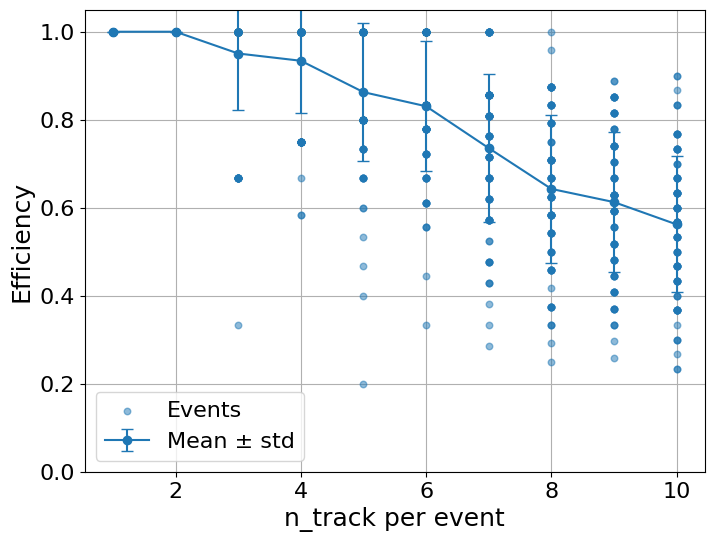

In [ ]:
df_all = pd.read_csv(save)

plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 23,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

x = df_all['n_track'].astype(int).values
y = df_all['accuracy'].astype(float).values

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=22, alpha=0.5, label='Events', zorder=2)

g = df_all.groupby('n_track')['accuracy']
xg = g.mean().index.values
yg = g.mean().values
yerr = g.std().fillna(0).values

plt.errorbar(xg, yg, yerr=yerr, fmt='o-', capsize=4, linewidth=1.5, label='Mean ± std')

plt.xlabel('n_track per event')
plt.ylabel('Efficiency')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


final_png = path / "res" / "plot_res_HT.png"
# plt.savefig(final_png, bbox_inches='tight')

#### This notebook contains everything necessary to reproduce the plots presented in my Bachelor’s thesis. Nevertheless, I chose to share the original data I used for these plots.

- The **`gen1`** folder contains the *inclined* dataset, with two miss probabilities, reconstructed using two different algorithms.  
- The **`gen2`** folder contains the *isotropic* dataset, also with two miss probabilities, reconstructed using the same two algorithms.  
- The **`res_thesis`** folder includes all results obtained with the different datasets and reconstruction methods.  

**Naming convention:**
- **`met1`** → *Combinatorial* reconstruction method  
- **`met2`** → *HT* (Hough Transform) reconstruction method  
- **`m`** → *Miss* datasets  
- **`nm`** → *No-miss* datasets  
- **`gen1`** → *Inclined* dataset  
- **`gen2`** → *Isotropic* dataset
